Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Speed   mean = 107.96, std = 72.03
Capacity mean = 6.74, std = 4.73

Top-10 countries (count of peers):
Country
United States         697
Unknown               500
Russian Federation    317
Germany               277
Netherlands           167
Canada                149
China                 131
United Kingdom        128
Australia              94
Poland                 72


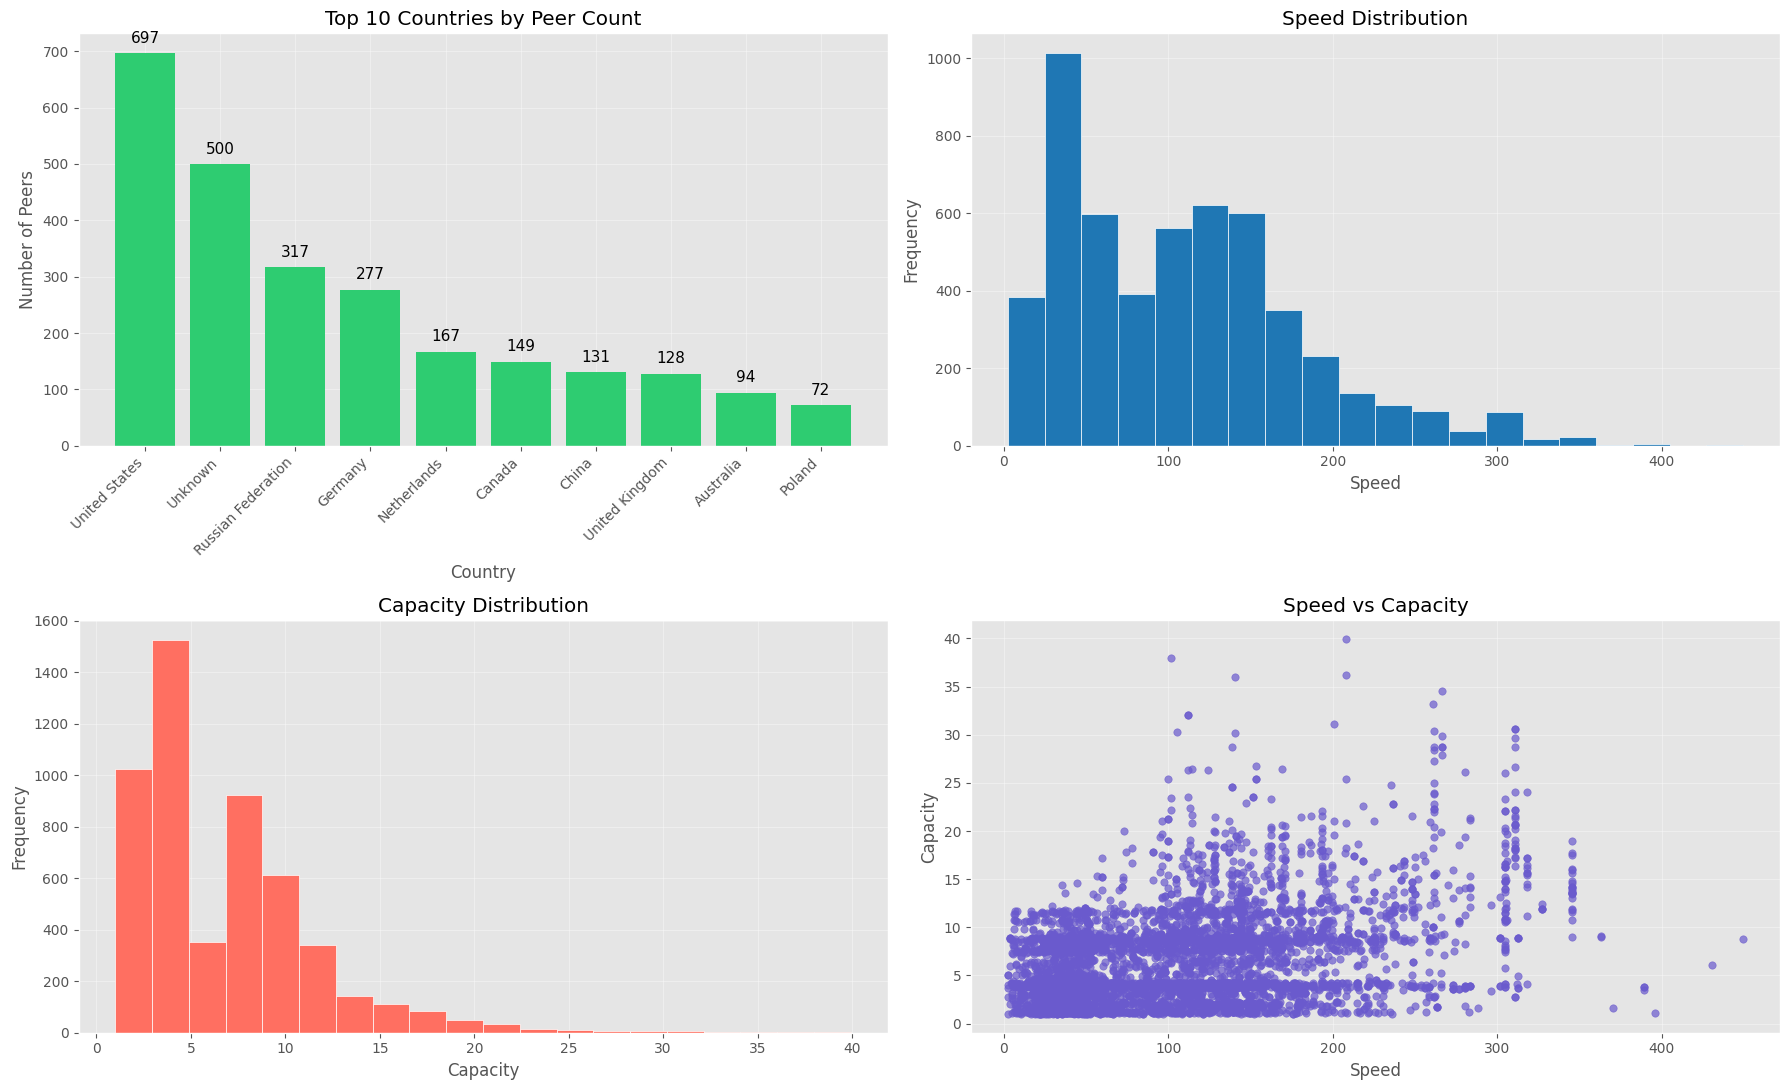


Saved combined figure to: /content/drive/MyDrive/DataInBrief-2025/Fig7-Profiles-Overview-2x2.png


In [5]:
# ============================================
# Fig 7 – I2P Peer Profiles Overview (2×2)
# Source files (exact):
#   /content/drive/MyDrive/DataInBrief-2025/9-Profile-By-Country.csv
#   /content/drive/MyDrive/DataInBrief-2025/10-Profiles-By-Country.csv
# Output:
#   /content/drive/MyDrive/DataInBrief-2025/Fig7-Profiles-Overview-2x2.png
# ============================================
# 1) Mount Drive (idempotent)
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2) Paths
P_COUNTS = Path("/content/drive/MyDrive/DataInBrief-2025/9-Profile-By-Country.csv")
P_PROF   = Path("/content/drive/MyDrive/DataInBrief-2025/10-Profiles-By-Country.csv")
OUT_FIG  = Path("/content/drive/MyDrive/DataInBrief-2025/Fig7-Profiles-Overview-2x2.png")

# 3) Load with robust parser (tolerates stray quotes/lines)
def read_csv_robust(path: Path) -> pd.DataFrame:
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_csv(path, engine="python", on_bad_lines="skip")

df9  = read_csv_robust(P_COUNTS)
df10 = read_csv_robust(P_PROF)

# 4) Clean/normalize required columns
# --- country counts (use df9 which is already 'by country'); fallback to df10 if needed
if "Country" not in df9.columns:
    raise ValueError(f"'Country' column not found in {P_COUNTS}. Found: {list(df9.columns)}")
countries = (
    df9["Country"]
    .astype(str)
    .str.strip()
    .replace({"": "Unknown", "nan": "Unknown", "None": "Unknown", "unknown": "Unknown"})
)
top10 = countries.value_counts().head(10)

# --- numerics for hist/scatter (use df10, which has many rows)
for col in ("Speed", "Capacity", "Country"):
    if col not in df10.columns:
        raise ValueError(f"'{col}' column not found in {P_PROF}. Found: {list(df10.columns)}")

df10_clean = df10.copy()
df10_clean["Country"]  = df10_clean["Country"].astype(str).str.strip().replace(
    {"": "Unknown", "nan": "Unknown", "None": "Unknown", "unknown": "Unknown"}
)
# Coerce numeric, turn "--" or text into NaN
df10_clean["Speed"]    = pd.to_numeric(df10_clean["Speed"], errors="coerce")
df10_clean["Capacity"] = pd.to_numeric(df10_clean["Capacity"], errors="coerce")

df_num = df10_clean.dropna(subset=["Speed", "Capacity"]).copy()

# 5) Statistics (from your data)
speed_mean = df_num["Speed"].mean()
speed_std  = df_num["Speed"].std(ddof=1)
cap_mean   = df_num["Capacity"].mean()
cap_std    = df_num["Capacity"].std(ddof=1)

print(f"Speed   mean = {speed_mean:.2f}, std = {speed_std:.2f}")
print(f"Capacity mean = {cap_mean:.2f}, std = {cap_std:.2f}")
print("\nTop-10 countries (count of peers):")
print(top10.to_string())

# 6) Figure: 2×2 panels with your colors
plt.style.use("ggplot")  # light gray grid like your sample
fig, axes = plt.subplots(2, 2, figsize=(18, 11))
(ax_bar, ax_hist_speed), (ax_hist_cap, ax_scatter) = axes

# --- (1) Top-10 Countries (green) — vertical bars with labels
x_labels = top10.index.tolist()
y_vals   = top10.values
ax_bar.bar(x_labels, y_vals, color="#2ecc71")
ax_bar.set_ylabel("Number of Peers")
ax_bar.set_xlabel("Country")
ax_bar.set_title("Top 10 Countries by Peer Count")
# rotate x labels for readability
for tick in ax_bar.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha("right")
# annotate each bar with its count
for i, v in enumerate(y_vals):
    ax_bar.text(i, v + max(3, int(top10.max() * 0.02)), f"{int(v)}", ha="center", va="bottom", fontsize=11)

# --- (2) Speed histogram (blue)
ax_hist_speed.hist(df_num["Speed"], bins=20, color="#1f77b4", edgecolor="white")
ax_hist_speed.set_xlabel("Speed")
ax_hist_speed.set_ylabel("Frequency")
ax_hist_speed.set_title("Speed Distribution")

# --- (3) Capacity histogram (salmon)
ax_hist_cap.hist(df_num["Capacity"], bins=20, color="#ff6f61", edgecolor="white")
ax_hist_cap.set_xlabel("Capacity")
ax_hist_cap.set_ylabel("Frequency")
ax_hist_cap.set_title("Capacity Distribution")

# --- (4) Scatter: Speed vs Capacity (purple)
ax_scatter.scatter(df_num["Speed"], df_num["Capacity"], s=28, alpha=0.7, color="#6a5acd")
ax_scatter.set_xlabel("Speed")
ax_scatter.set_ylabel("Capacity")
ax_scatter.set_title("Speed vs Capacity")

fig.tight_layout()
OUT_FIG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_FIG, dpi=220)
plt.show()

print(f"\nSaved combined figure to: {OUT_FIG}")


In [6]:
# --- AUDIT: prove the figure is data-driven (no hardcoding) ---
from pathlib import Path
import pandas as pd
import numpy as np

P_COUNTS = Path("/content/drive/MyDrive/DataInBrief-2025/9-Profile-By-Country.csv")
P_PROF   = Path("/content/drive/MyDrive/DataInBrief-2025/10-Profiles-By-Country.csv")

df9  = pd.read_csv(P_COUNTS, engine="python", on_bad_lines="skip")
df10 = pd.read_csv(P_PROF,   engine="python", on_bad_lines="skip")

# Normalize country names; coerce numerics
countries = (
    df9["Country"].astype(str).str.strip()
        .replace({"": "Unknown", "nan": "Unknown", "None": "Unknown", "unknown": "Unknown"})
)
top10 = countries.value_counts().head(10)

df10c = df10.copy()
df10c["Speed"]    = pd.to_numeric(df10c["Speed"], errors="coerce")
df10c["Capacity"] = pd.to_numeric(df10c["Capacity"], errors="coerce")
df10c = df10c.dropna(subset=["Speed", "Capacity"])

# Print what the code is actually using
print("Files used:")
print(" -", P_COUNTS, "rows:", len(df9))
print(" -", P_PROF,   "rows:", len(df10))
print("\nTop-10 countries (from 9-Profile-By-Country.csv):")
print(top10.to_string())

print("\nSpeed/Capacity stats (from 10-Profiles-By-Country.csv):")
print("  Speed   mean =", round(df10c["Speed"].mean(), 2), "std =", round(df10c["Speed"].std(ddof=1), 2))
print("  Capacity mean =", round(df10c["Capacity"].mean(), 2), "std =", round(df10c["Capacity"].std(ddof=1), 2))

# Simple check that United States is #1 (case-insensitive)
top_country = top10.index[0]
print("\nTop country detected:", top_country)
if "united states" in top_country.lower():
    print("✔ United States is the highest (as expected).")
else:
    print("⚠ Top is not 'United States'—double-check the 'Country' values or spelling in the CSV.")


Files used:
 - /content/drive/MyDrive/DataInBrief-2025/9-Profile-By-Country.csv rows: 3444
 - /content/drive/MyDrive/DataInBrief-2025/10-Profiles-By-Country.csv rows: 51399

Top-10 countries (from 9-Profile-By-Country.csv):
Country
United States         697
Unknown               500
Russian Federation    317
Germany               277
Netherlands           167
Canada                149
China                 131
United Kingdom        128
Australia              94
Poland                 72

Speed/Capacity stats (from 10-Profiles-By-Country.csv):
  Speed   mean = 107.96 std = 72.03
  Capacity mean = 6.74 std = 4.73

Top country detected: United States
✔ United States is the highest (as expected).


In [8]:
# ===== Fig 7 — Audit + Compute (Colab) =====
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)
except Exception:
    pass

from pathlib import Path
import pandas as pd
import numpy as np
import hashlib

# Paths
P9  = Path("/content/drive/MyDrive/DataInBrief-2025/9-Profile-By-Country.csv")
P10 = Path("/content/drive/MyDrive/DataInBrief-2025/10-Profiles-By-Country.csv")

def sha256sum(p: Path) -> str:
    return hashlib.sha256(p.read_bytes()).hexdigest()

def read_csv_robust(p: Path) -> pd.DataFrame:
    if not p.exists():
        raise FileNotFoundError(f"Missing file: {p}")
    return pd.read_csv(p, engine="python", on_bad_lines="skip")

# Load
df9  = read_csv_robust(P9)
df10 = read_csv_robust(P10)

print("Files loaded:")
print(" 9-Profile-By-Country.csv:", len(df9), "rows, sha256:", sha256sum(P9))
print("10-Profiles-By-Country.csv:", len(df10), "rows, sha256:", sha256sum(P10))
print("\nColumns (9):", list(df9.columns))
print("Columns (10):", list(df10.columns))

# ---- Canonicalize country names (only for values that appear) ----
def canonicalize_country_series(s: pd.Series) -> pd.Series:
    s = (s.astype(str).str.strip())
    # Normalize common empties/unknowns
    s = s.replace({"": "Unknown", "nan": "Unknown", "None": "Unknown", "unknown": "Unknown", "UNK": "Unknown"})
    # Lightweight synonym mapping (applied ONLY if those keys exist)
    mapping = {
        "USA": "United States",
        "U.S.A.": "United States",
        "United States of America": "United States",
        "US": "United States",
        "UK": "United Kingdom",
        "Great Britain": "United Kingdom",
        "England": "United Kingdom",
        "Russia": "Russian Federation",
    }
    present = {k: v for k, v in mapping.items() if k in set(s.unique())}
    if present:
        s = s.replace(present)
    return s

# Validate required columns
for col in ["Country"]:
    if col not in df9.columns:
        raise ValueError(f"Missing '{col}' in 9-Profile-By-Country.csv: {list(df9.columns)}")
for col in ["Country", "Speed", "Capacity"]:
    if col not in df10.columns:
        raise ValueError(f"Missing '{col}' in 10-Profiles-By-Country.csv: {list(df10.columns)}")

# Clean columns
df9_clean = df9.copy()
df9_clean["Country"] = canonicalize_country_series(df9_clean["Country"])

df10_clean = df10.copy()
df10_clean["Country"]  = canonicalize_country_series(df10_clean["Country"])
df10_clean["Speed"]    = pd.to_numeric(df10_clean["Speed"], errors="coerce")
df10_clean["Capacity"] = pd.to_numeric(df10_clean["Capacity"], errors="coerce")

# Compute Top-10 from BOTH sources
top9  = df9_clean["Country"].value_counts()
top10c = df10_clean["Country"].value_counts()

# Align and compare (sanity check)
cmp = pd.DataFrame({"from_9": top9, "from_10": top10c}).fillna(0).astype(int)
cmp["abs_delta"] = (cmp["from_9"] - cmp["from_10"]).abs()
cmp_sorted = cmp.sort_values("from_9", ascending=False)

# Select Top-10 list for plotting from df9 (matches your sample)
top10_countries = top9.head(10)

print("\nTop-10 from 9-Profile-By-Country.csv:")
print(top10_countries.to_string())

# Speed/Capacity stats from df10
df_num = df10_clean.dropna(subset=["Speed", "Capacity"])
speed_mean = df_num["Speed"].mean()
speed_std  = df_num["Speed"].std(ddof=1)
cap_mean   = df_num["Capacity"].mean()
cap_std    = df_num["Capacity"].std(ddof=1)
print(f"\nSpeed: mean={speed_mean:.2f}, std={speed_std:.2f}")
print(f"Capacity: mean={cap_mean:.2f}, std={cap_std:.2f}")

# Optional: show where 9 vs 10 differ (helps diagnose if your counts ever look off)
mismatch = cmp_sorted.head(20)
print("\nTop countries, comparison of counts (9 vs 10) — first 20 rows:")
print(mismatch.to_string(max_rows=20))

# Stash results for the plotting cell
top10_table = top10_countries.copy()
speed_series = df_num["Speed"].copy()
cap_series   = df_num["Capacity"].copy()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files loaded:
 9-Profile-By-Country.csv: 3444 rows, sha256: d9902751ae5e038b1c0b2c2e71484a6168a4b2b6d0014968b92373d56fdcad5f
10-Profiles-By-Country.csv: 51399 rows, sha256: c18e1c734f7e3189e4dd1758ea627799600590a67528c47b83361834655bf8a2

Columns (9): ['Timestamp', 'RouterPort', 'Peer', 'Country', 'Groups', 'Caps', 'Version', 'Speed', 'Capacity']
Columns (10): ['Timestamp', 'Country', 'Node Abbrev', 'Full Node ID', 'Groups', 'Caps', 'Version', 'Speed', 'Capacity', 'Integration', 'Status', 'IP Address']

Top-10 from 9-Profile-By-Country.csv:
Country
United States         697
Unknown               500
Russian Federation    317
Germany               277
Netherlands           167
Canada                149
China                 131
United Kingdom        128
Australia              94
Poland                 72

Speed: mean=107.96, std=72.03
Capacity: mean=6.74, std=

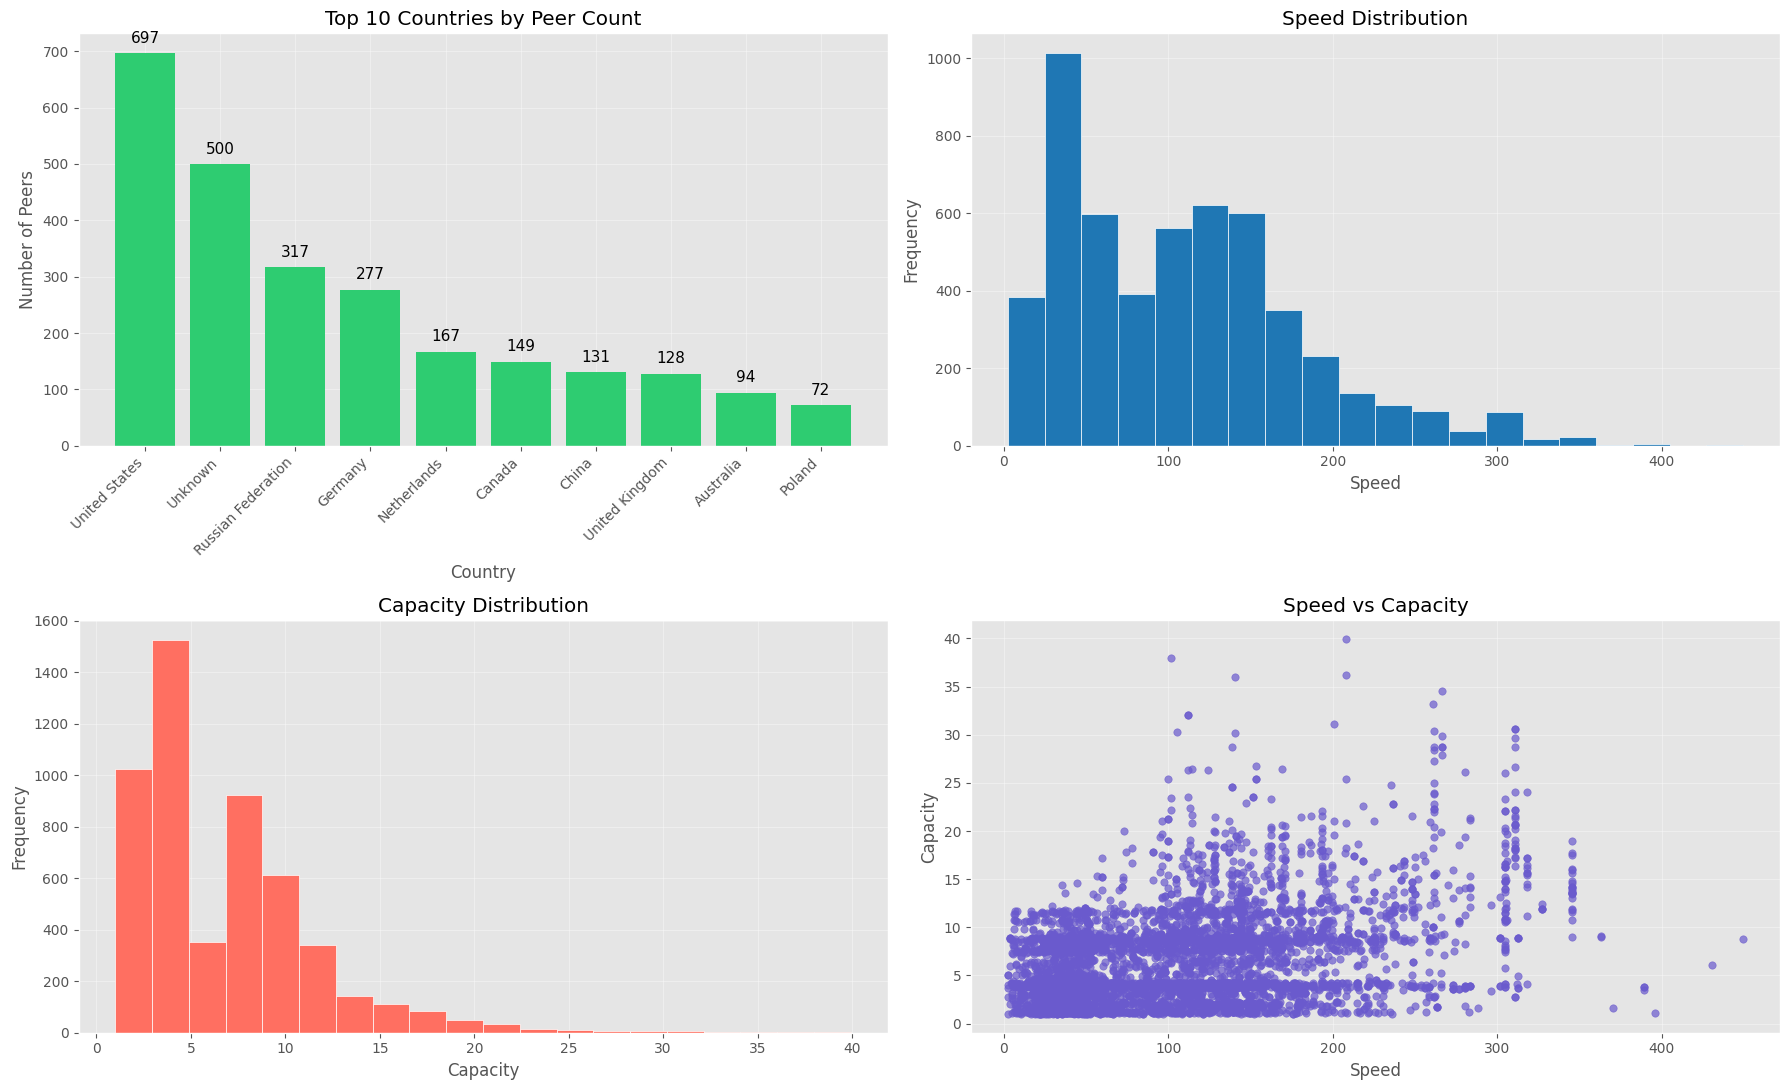

Saved combined figure to: /content/drive/MyDrive/DataInBrief-2025/Fig7-Profiles-Overview-2x2.png


In [9]:
# ===== Fig 7 — Plot 2×2 and save =====
from pathlib import Path
import matplotlib.pyplot as plt

OUT_FIG = Path("/content/drive/MyDrive/DataInBrief-2025/Fig7-Profiles-Overview-2x2.png")

plt.style.use("ggplot")  # light grid as in your sample
fig, axes = plt.subplots(2, 2, figsize=(18, 11))
(ax_bar, ax_hist_speed), (ax_hist_cap, ax_scatter) = axes

# 1) Top-10 Countries (green)
x_labels = top10_table.index.tolist()
y_vals   = top10_table.values
ax_bar.bar(x_labels, y_vals, color="#2ecc71")
ax_bar.set_ylabel("Number of Peers")
ax_bar.set_xlabel("Country")
ax_bar.set_title("Top 10 Countries by Peer Count")
for tick in ax_bar.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha("right")
mx = int(top10_table.max())
for i, v in enumerate(y_vals):
    ax_bar.text(i, v + max(3, int(mx * 0.02)), f"{int(v)}", ha="center", va="bottom", fontsize=11)

# 2) Speed histogram (blue)
ax_hist_speed.hist(speed_series.dropna(), bins=20, color="#1f77b4", edgecolor="white")
ax_hist_speed.set_xlabel("Speed")
ax_hist_speed.set_ylabel("Frequency")
ax_hist_speed.set_title("Speed Distribution")

# 3) Capacity histogram (salmon)
ax_hist_cap.hist(cap_series.dropna(), bins=20, color="#ff6f61", edgecolor="white")
ax_hist_cap.set_xlabel("Capacity")
ax_hist_cap.set_ylabel("Frequency")
ax_hist_cap.set_title("Capacity Distribution")

# 4) Scatter (purple)
ax_scatter.scatter(speed_series, cap_series, s=28, alpha=0.7, color="#6a5acd")
ax_scatter.set_xlabel("Speed")
ax_scatter.set_ylabel("Capacity")
ax_scatter.set_title("Speed vs Capacity")

fig.tight_layout()
OUT_FIG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_FIG, dpi=220)
plt.show()

print("Saved combined figure to:", OUT_FIG)
